# 📰 EXP 08. 뉴스 요약 봇 만들기 


* 이번 시간엔 아마존 리뷰 데이터셋을 가져와 자연어 처리 라이브러리 NLTK(Natural Language Toolkit)를 이용해 데이터셋에서 불용어를 제거하고, 데이터셋을 전처리 해 자연어 생성 모델 seq2seq를 구축하여 원문을 추상적 요약, 추출적 요약 2가지로 요약 해 보았다. 
* 이전에 했던 자연어 처리 모델과는 다른점은 많았지만, 과정 자체는 변함 없었다. 
* 노드에서 진행했던 내용을 토대로 뉴스 기사 데이터를 요약해 보는 봇을 만들어 보겠습니다. 



----




# 📋 루브릭 평가 기준


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다. |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. | 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다. |
| 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다. |



----




# 목차


## 1. 데이터 수집하기 

## 2. 데이터 전처리 하기

## 3. 모델 설계하기 

## 4. 어텐션 메커니즘 사용하기

## 5. 모델 훈련 및 예측

## 6. 실제 결과와 요약문 비교하기

## 7. Summa를 이용해서  추출적 요약 해 보기

## 회고!

## 🖇️ 참고 페이지


### ※ 참고 : 2~4번에선 추상적 요약으로 이루어져야 합니다. 



---



# 1. 데이터 수집하기   



* 이번 EXP에선 [뉴스기사 데이터](https://github.com/sunnysai12345/News_Summary)를 사용합니다. 


* 우선 필요한 모듈을 불러와 준 후, 데이터를 수집해 보겠습니다. 

## &nbsp;&nbsp; 1-1 필요한 라이브러리 불러오기

In [86]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import AdditiveAttention
#추출적 요약 summa 패키지 
import requests
from summa.summarizer import summarize


print('~🎵🎶')


~🎵🎶


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## &nbsp;&nbsp; 1-2 데이터 다운로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('뉴스기사 데이터 다운로드 완료!')

뉴스기사 데이터 다운로드 완료!


In [3]:
# 데이터가 잘 다운로드 됬나 확인 해 봅시다!
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
# 0번째 행 headline 내용 확인해보기 
data.iloc[0,0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [5]:
# 0번째 행 text 내용 확인해보기 
data.iloc[0,1]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

* 이 데이터는 기사의 본문에 해당되는 text와 headline 두 가지 열로 구성되어있다. 아마존 리뷰 데이터에선 userID, iD 등 불필요한 부분이 있었기에 data에서 Text 와 Summary 부분을 따로 빼 와 줬지만, 이번 데이터셋은 그대로 써도 되니 편하다 😊 


* **추상적 요약을 하는 경우** : _text를 본문, headline을 이미 요약된 데이터_ 로 삼아서 모델을 학습합니다. 
* **추출적 요약을 하는경우** : 오직 _text 열만_ 사용 


* 먼저 추상적 요약을 해 볼것이기 때문에, text는 본문, headline을 summary로 보면 되겠죠?



---



# 2. 데이터 전처리 하기


* 우선 중복 샘플이 존재하는 지 확인 해 보고 중복 샘플을 제거합니다.
* 그 후, Null 값이 존재하는지 확인 해 보고 Null값이 있다면 제거합니다.

## &nbsp;&nbsp; 2-1 중복 샘플 유무를 확인합니다.

In [6]:
# 확인 과정에서 데이터의 열 이름을 확인 해 줍니다. 

total_data_len = len(data) # 중복 제거 전 총 샘플의 수 
text_nunique_count = data['text'].nunique() # text 열에서 중복을 배제한 유일한 샘플 수 
head_nunique_count = data['headlines'].nunique()


print('중복 제거 전 총 샘플의 수 : ', total_data_len) 
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', text_nunique_count)
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', head_nunique_count)
print('-'*30)
print('text 열의 중복 개수 :',total_data_len-text_nunique_count)
print('headlines 열의 중복 개수 :',total_data_len-head_nunique_count)


중복 제거 전 총 샘플의 수 :  98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
------------------------------
text 열의 중복 개수 : 41
headlines 열의 중복 개수 : 121


## &nbsp;&nbsp; 2-2 중복 샘플 제거하기


* ```drop_duplicates()```을 이용해 중복 샘플을 제거해줍니다.

In [7]:
# inplace=True를 설정하면 DataFrame 타입 값을 return하지 않고 data 내부를 직접적으로 바꿈.
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복이 제거된 전체 샘플의 수 : ',len(data))

중복이 제거된 전체 샘플의 수 :  98360


In [8]:
data['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98360, dtype: object

In [9]:
data['headlines']

0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
                               ...                        
98396    CRPF jawan axed to death by Maoists in Chhatti...
98397    First song from Sonakshi Sinha's 'Noor' titled...
98398           'The Matrix' film to get a reboot: Reports
98399    Snoop Dogg aims gun at clown dressed as Trump ...
98400    Madhesi Morcha withdraws support to Nepalese g...
Name: headlines, Length: 98360, dtype: object

In [11]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', text_nunique_count)
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', head_nunique_count)

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


* 두 열의 숫자가 98360 으로 같은걸로 보아, text열 뿐만 아니라 headlines의 중복 데이터도 함께 제거된걸 확인할 수 있다.

* 하지만, headline에서 중복을 배제한 유일한 샘플 수가 98,280개 인걸 보니 아직 더 해줘야 하는게 남은것 같다. headlines의 내용은 같지만 text 내용이 다른 샘플이 있는걸까?

## &nbsp;&nbsp; 2-3 Null 값 확인하기

In [12]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* null값은 없으니, dropna()로 제거 해 줄 필욘 없는것같다.

## &nbsp;&nbsp; 2-4 텍스트 정규화 (text normalization)


* 살아남은 샘플 갯수 98,360개 중에서 같은 뜻이지만 다른 단어로 간주되는 경우를 한 단어로 통일해 주는 작업을 진행합니다. 
    * ```it'll```은 ```it will```과 같고, ```mustn't```과 ```must not```은 같은 표현
    * 이런 경우, 기계가 굳이 이들을 다른 단어로 간주해서 연산량을 늘리는 것 보단, 
        학습 전에 미리 같은 표현으로 통일 해 주는게 좋습니다.
    * [텍스트 정규화 참고 링크](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [13]:
# 텍스트 정규화를 위한 사전을 구성합니다. 

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


## &nbsp;&nbsp; 2-5 불용어 리스트 


* NLTK에서 미리 정의하여 제공하는 불용어 리스트를 이용해 불용어를 제거 해 줍니다. 
* 우선 불용어를 확인 합니다.

In [14]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

## &nbsp;&nbsp; 2-6 데이터 전처리 함수 만들기


* 데이터 전처리를 위한 함수를 만들었습니다. 
* 추상적인 문장 요약 결과문이 자연스러운 문장이 되려면 불용어가 Headline엔 남아있는게 더 좋다고 생각하기 때문에 headline에는 불용어를 사용하지 않습니다.

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [18]:
# 만든 전처리 함수를 사용해서 잘 걸러지는지 확인 해봅시다. 

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headline:", preprocess_sentence(temp_headlines, False))  
# headline은 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headline: great way to start the day


## &nbsp;&nbsp; 2-7 데이터 전체에 전처리 수행하기

* Headline에는 불용어를 제거하지 않기 때문에, 데이터 전처리는 text와 headline을 따로 처리 해줍니다. 





### &nbsp;&nbsp;&nbsp;&nbsp; 2-7-1 text 데이터에 전처리 수행하기

In [19]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])


Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur




### &nbsp;&nbsp;&nbsp;&nbsp; 2-7-2 headline 데이터에 전처리 수행하기

* 불용어를 제거하지 않기 때문에, false를 추가합니다. 

In [20]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


## &nbsp;&nbsp; 2-8 빈 샘플 확인


* 텍스트 정제 과정을 거친 후엔 정제 전엔 데이터가 있던 부분도 없어졌을 수도 있기 때문에 꼭 한번씩 확인 해 보는것이 좋습니다.




### &nbsp;&nbsp;&nbsp;&nbsp; 2-8-1 정제 후 빈 값을 Null로 변환

In [21]:
# 보다 쉽게 확인 하기 위해 데이터들을 데이터 프레임에 재 저장. 
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('Null 값 변환 완료~!')

Null 값 변환 완료~!





### &nbsp;&nbsp;&nbsp;&nbsp; 2-8-2 Null 값이 생겼는지 확인 

In [22]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## &nbsp;&nbsp; 2-9 샘플의 최대 길이 정하기 


* 훈련에 사용할 샘플의 최대 길이를 정해줍니다. 




### &nbsp;&nbsp;&nbsp;&nbsp; 2-9-1 text와 headlines 의 최소, 최대, 평균 길이를 구하고, 길이 분포를 시각화.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


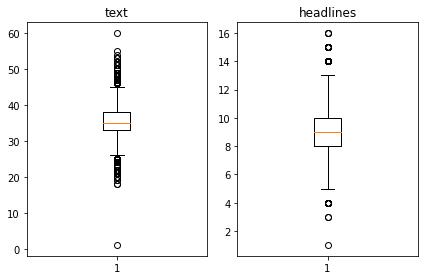

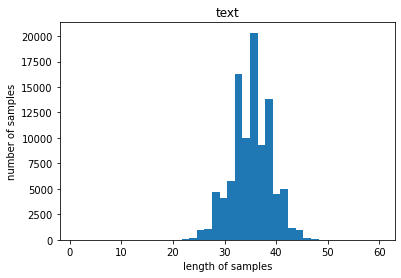

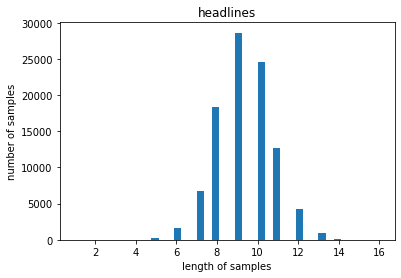

In [23]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 짧은 뉴스라 그런가 문장 길이가 리뷰만큼 길지 않다. 대체적으로 적당히 긴 문장 들로 구성 되어 있는 것 같은데..? 
~~~ 짧...은가..? ~~~ 

> text 내용   
"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."




### &nbsp;&nbsp;&nbsp;&nbsp; 2-9-2 Text의 최대 길이와 Summary의 적절한 최대 길이 설정

* 아래 설정한 최대길이 대비 데이터 비율을 확인 해 보고, 얼마만큼 날릴건지 생각 해 보자.
* 길이가 너무 길면 패딩이 많이 들어가야하니까 잘 생각해 보자
* 최대 길이보다 길이가 긴 문장들은 길이만큼 잘린다.
* 시각화 해 봤을 때, 데이터의 분포가 고른걸 보아 데이터를 구지 솎아 줄 필요가 없는것 같아 최대 길이로 설정해주었다. 

In [27]:
text_max_len = 42
headline_max_len = 11

print('최대길이 설정 완료! ')

최대길이 설정 완료! 




* 그렇다면 내가 설정했던 최대 길이들이 데이터 상에 얼마나 되는지 비율을 한번 확인 해보자.

In [28]:
# 데이터의 비율을 계산 하는 함수! 
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# text와 headlines에 적용해봅시다. 
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 11 이하인 샘플의 비율: 1.0





### &nbsp;&nbsp;&nbsp;&nbsp; 2-9-3 데이터가 최대 길이보다 길면 제외하는 방법으로 정제합니다.


In [29]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


* 최대길이를 30, 8 로 설정했을 때 65295개였던 샘플이, 약 8000개 가량 더 추가되었다. 
* 너무 길다 싶은 문장만 솎아줄 것이기 때문에, 샘플 길이는 길이 분포를 참조해 적당히 맞춰주었다.

## &nbsp;&nbsp; 2-10 시작 토큰과 종료 토큰 추가하기!


1. 디코더의 입력
    1. 디코더의 입력에 해당되면서 시작 토큰이 맨 앞에 있는 문장 이름 = `decoder_input`
    2. 디코더의 출력에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장 이름 = `decoder_target`
2. 레이블에 시작 토큰과 종료 토큰을 추가
    1. 시작 토큰 : `sostoken ` . 문장 앞에 추가 <start>
    2. 종료 토큰 : `eostoken` . 문장 뒤에 추가 <end>
    
* 토큰 이름을 임의로 정의해 주셨다고 봤던 것 같아, sostoken 라는 말만 있는건 좀.. 한번에 봤을 때 표가 잘 안나는 것 같아, exp4에서 해 줬던 이름으로 바꿔보았다.
    (문제 생길 시 원복 예정)

In [30]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


* 토큰이 잘 추가 됬는지, 하나하나 따 와서 확인 해봤습니다.

In [31]:
data.iloc[1,2]

'sostoken aegon life iterm insurance plan helps customers save tax'

In [32]:
data.iloc[1,3]

'aegon life iterm insurance plan helps customers save tax eostoken'




### &nbsp;&nbsp;&nbsp;&nbsp; 2-10-1 토큰을 추가한 데이터들을 numpy 타입으로 변경합니다


In [33]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

print('Numpy 타입 변환 완료!')

Numpy 타입 변환 완료!


## &nbsp;&nbsp; 2-11 훈련 데이터와 테스트 데이터 분리하기




### &nbsp;&nbsp;&nbsp;&nbsp; 2-11-1 정수 시퀀스 만들기

* encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만듭니다

In [34]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21453 49848 37204 ... 63421 50245  7289]





### &nbsp;&nbsp;&nbsp;&nbsp; 2-11-2 정수 시퀀스의 데이터 샘플 재정의


In [35]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print('Everyday I\'m Shuffling.')

Everyday I'm Shuffling.





### &nbsp;&nbsp;&nbsp;&nbsp; 2-11-3 test data 크기 정의하기  
- 전체 데이터의 크기에서 0.2를 곱해 test 데이터의 크기를 정의합니다.


In [36]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수:', n_of_val)

테스트 데이터의 수: 14820





### &nbsp;&nbsp;&nbsp;&nbsp; 2-11-4 데이터 나누기
- 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 나눠줍니다.
- : 표시의 위치에 주의!

In [53]:
# train data 
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

#test data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


## &nbsp;&nbsp; 2-12 단어 집합(Vocabulary) 만들기


### 단어 집합 = 각 단어에 고유한 정수를 맵핑하는 작업시 만들어지는 집합

* keras의 토크나이저를 사용해서 단어집합을 만듭니다. 
    * 토크나이저를 통해 만들면 좋은점 : 입력된 훈련 데이터로부터 단어집합을 만들 수 있다! 

In [54]:
# train data에 대한 단어집합을 만듭니다. 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train)
# 입력된 데이터로부터 단어 집합 생성
print('train data 단어 집합 생성 완료!')

train data 단어 집합 생성 완료!


In [55]:
# test data에도 단어 집합 생성 + 각 단어에 고유한 정수를 부여합니다. 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('test data 단어 집합 생성 완료!')

test data 단어 집합 생성 완료!





### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-1 훈련 데이터 내 단어 빈도수 확인

* 사용 빈도가 낮은 단어들을 훈련에서 제외할 것이기 때문에, 우선 단어의 빈도수를 확인 하는 작업을 거칩니다. 

In [56]:
threshold = 4 # 등장 빈도 
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61398
등장 빈도가 3번 이하인 희귀 단어의 수: 35371
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26027
단어 집합에서 희귀 단어의 비율: 57.60936838333496
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.6094246519726108


* 지금 우리가 사용하는 데이터셋은 뉴스의 데이터셋. 보도자료 이기 때문에, 중복되는 단어가 그렇게 많이 없을거라 생각해서,. 등장 빈도를 4로 줬습니다. 등장 빈도가 3 이하인 희귀 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하겠습니다.




### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-2 확인한 빈도수를 토대로 집합 크기를 제한. 

* 희귀단어를 제외시킬 경우 단어집합 크기가 24250, 24000개로 해보자 

In [57]:
src_vocab = 25000

# 단어 집합의 크기를 26000개로 제한합니다. 
src_tokenizer = Tokenizer(num_words=src_vocab)

# 단어 집합을 재생성합니다. 
src_tokenizer.fit_on_texts(encoder_input_train)

print('단어집합 재 생성이 완료! 되었! 습니다! ! ')

단어집합 재 생성이 완료! 되었! 습니다! ! 





### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-3 시퀀스를 정수 시퀀스로 변환

* ```texts_to_sequences()``` : 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 함수. 

In [58]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 변환 되었나 확인 해볼까요? 
print(encoder_input_train[:3])

[[65, 423, 83, 1616, 157, 10626, 1700, 5682, 437, 1616, 162, 160, 82, 25, 354, 10, 155, 1100, 1700, 160, 11337, 3426, 224, 2473, 3749, 2660, 224, 540, 2460, 2238, 437, 950, 52, 19, 1520, 78, 23], [20912, 9286, 3627, 20913, 390, 10, 39, 301, 31, 22, 3972, 2252, 662, 909, 706, 3305, 3459, 244, 204, 480, 1200, 22, 2201, 4668, 20913, 384, 6457, 2564, 5336, 4668, 1823, 23140, 213, 662, 2217, 1079], [7398, 1020, 1348, 1545, 35, 32, 3, 121, 233, 2136, 144, 142, 993, 35, 1057, 107, 9075, 110, 1186, 360, 127, 671, 64, 1020, 1279, 5608, 5214, 144, 731, 2136, 74, 7941, 7134]]





### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-4 test 데이터 내 단어 빈도수 확인

* 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산합니다. 

In [59]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('test data 단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

test data 단어 집합(vocabulary)의 크기 : 27334
등장 빈도가 3번 이하인 희귀 단어의 수: 15783
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11551
단어 집합에서 희귀 단어의 비율: 57.74127460305846
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.095013930252666





### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-5 test 데이터 단어 집합 크기를 제한, 정수 시퀀스로 변환하기 

In [60]:
tar_vocab = 11000 # test 단어 집합 제외 시키고 난 다음의 크기가 10826
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('-'*30)
print('target')
print('decoder ',decoder_target_train[:5])


input
input  [[1, 3229, 793, 3, 1531, 76, 1556], [1, 6987, 166, 845, 1093, 24, 745, 10, 684, 3327], [1, 7544, 966, 5737, 18, 1322, 607, 7, 1374, 95, 53], [1, 626, 3, 706, 22, 3, 579, 767, 536, 1557], [1, 906, 3967, 3116, 1021, 3, 521, 337]]
------------------------------
target
decoder  [[3229, 793, 3, 1531, 76, 1556, 2], [6987, 166, 845, 1093, 24, 745, 10, 684, 3327, 2], [7544, 966, 5737, 18, 1322, 607, 7, 1374, 95, 53, 2], [626, 3, 706, 22, 3, 579, 767, 536, 1557, 2], [906, 3967, 3116, 1021, 3, 521, 337, 2]]





### &nbsp;&nbsp;&nbsp;&nbsp; 2-12-6 빈 샘플이 있는지 다시한번 점검!


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다. =  빈도수가 낮은 단어만으로 구성된 샘플은 빈 샘플이 되었을 가능성이 있다. (짧은 문장이면 더더욱 영향이 크겠죠?)       
한번 확인 해 봅시다. 

In [61]:
# 요약문의 길이가 1인 경우의 인덱스를 저장. 
# train, test 두군데 다 해 줘야함. 
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


## &nbsp;&nbsp; 2-13 패딩하기!


* 정말 긴.... 데이터 전처리 과정이였다. 이제 끝이보인다! 


* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰준다. 


* 최대 길이는 text_max_len 에서 정해준대로!

In [62]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')
print('padding~ 완료~ ')

padding~ 완료~ 


In [63]:
encoder_input_train[0]

array([   65,   423,    83,  1616,   157, 10626,  1700,  5682,   437,
        1616,   162,   160,    82,    25,   354,    10,   155,  1100,
        1700,   160, 11337,  3426,   224,  2473,  3749,  2660,   224,
         540,  2460,  2238,   437,   950,    52,    19,  1520,    78,
          23,     0,     0,     0,     0,     0], dtype=int32)

In [64]:
encoder_input_test[0]

array([   12,   206,   441,   219,    24,   871,   722,   170,   339,
          22,   715,  5182,  3650,    52,    76,   149,    73,     6,
        4100,   170,   217,  6350,  1650,    95,   134,     8,    86,
        1502,  1931,  5784, 16197,  2212,  3713,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [65]:
decoder_input_train[0]

array([   1, 3229,  793,    3, 1531,   76, 1556,    0,    0,    0,    0],
      dtype=int32)

In [66]:
decoder_target_train[0]

array([3229,  793,    3, 1531,   76, 1556,    2,    0,    0,    0,    0],
      dtype=int32)

In [67]:
decoder_input_test[0]

array([   1,   51,   26,  187,    4,   36, 1384,  396,  102,    0,    0],
      dtype=int32)

In [68]:
decoder_target_test[0]

array([  51,   26,  187,    4,   36, 1384,  396,  102,    2,    0,    0],
      dtype=int32)




----





# 3. 모델 설계하기 

## &nbsp;&nbsp; 3-1 함수형 API를 이용해 인코더를 설계

In [69]:
# 인코더 설계 시작

# 임베딩 벡터의 차원
embedding_dim = 128 
# LSTM에서 얼만큼 수용력을 가질지 정하는 파라미터 
hidden_size = 256 

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## &nbsp;&nbsp; 3-2 디코더의 입력층 설계하기 

* 디코더 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하나, 입력층을 정의할 때 ```initial_state```의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다. 

In [70]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## &nbsp;&nbsp; 3-3 디코더의 출력층 설계하기 

In [71]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________



----




# 4. 어텐션 메커니즘 사용하기




* 어텐션 메커니즘은 디코더 출력층의 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이다. 
* LMS 상에선 Tensorflow에 이미 구현된 어텐션 함수를 가져와 디코더의 출력층에 결합하는 방식으로 사용함. 

In [72]:

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 5. 모델 훈련 및 예측 


* 설계한 모델을 가지고와 훈련을 진행합니다.
    * Earlystopping 을 사용해, 특정 조건이 충족(val_loss가 증가하는 현상이 2회 관측)되면 학습을 멈춥니다.
* 훈련 데이터의 손실과 검증 데이터의 손실 과정도 시각화 해 봅니다. 

## &nbsp;&nbsp; 5-1 모델 훈련하기 

In [73]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
116/116 [==============================] - 84s 640ms/step - loss: 6.2821 - val_loss: 5.8301
Epoch 2/50
116/116 [==============================] - 74s 638ms/step - loss: 5.7577 - val_loss: 5.5250
Epoch 3/50
116/116 [==============================] - 72s 624ms/step - loss: 5.4733 - val_loss: 5.2949
Epoch 4/50
116/116 [==============================] - 73s 628ms/step - loss: 5.2457 - val_loss: 5.1178
Epoch 5/50
116/116 [==============================] - 73s 626ms/step - loss: 5.0475 - val_loss: 4.9478
Epoch 6/50
116/116 [==============================] - 73s 629ms/step - loss: 4.8462 - val_loss: 4.8168
Epoch 7/50
116/116 [==============================] - 73s 628ms/step - loss: 4.6690 - val_loss: 4.6788
Epoch 8/50
116/116 [==============================] - 72s 622ms/step - loss: 4.5100 - val_loss: 4.5813
Epoch 9/50
116/116 [==============================] - 72s 621ms/step - loss: 4.3678 - val_loss: 4.5135
Epoch 10/50
116/116 [==============================] - 72s 620ms/step - l

## &nbsp;&nbsp; 5-2 훈련 데이터의 손실과 검증 데이터의 손실 과정 시각화

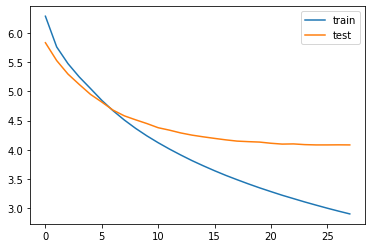

In [74]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()




-----





# 6. 실제 결과와 요약문 비교하기 

## &nbsp;&nbsp; 6-1 복원에 필요한 사전 미리 준비하기 


* 테스트 단계에선 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 언어 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비합니다.

In [75]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('사전 준비 완료!')

사전 준비 완료!


## &nbsp;&nbsp; 6-2 인코더 설계

In [76]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('인코더 설계!')

인코더 설계!


## &nbsp;&nbsp; 6-3 어텐션 메커니즘을 사용하는 출력층을 설계

In [77]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('출력층 설계!')

출력층 설계!


## &nbsp;&nbsp; 6-4 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [81]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

print('홤수! 만들었고!')

홤수! 만들었고!


## &nbsp;&nbsp; 6-5 모델 시험하기 


* 테스트 단계에선 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인해야합니다. 
* 우선, 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들고, 실제 요약과 예측된 요약을 비교 해 봅시다. 

### &nbsp;&nbsp; &nbsp;&nbsp; 6-5-1 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들기

In [82]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('함수! ')

함수! 


### &nbsp;&nbsp; &nbsp;&nbsp; 6-5-2 실제 요약과 예측된 요약을 비교하기 

In [144]:
# 하나하나 보기 위한 함수 
def ExSu(i):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

In [146]:
# 너무 많으니깐 10개만 가져와서 확인 해보겠습니다.

for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian reported dead injured new york terror attack near world trade center memorial tuesday pm narendra modi also condemned attack shared condolences deceased notably least people killed truck ran pedestrians cyclists bike path 
실제 요약 : no indian injured in new york terror attack 
예측 요약 :  indian army kills militants in pakistan


원문 : stepping delhi daredevils captain gautam gambhir said probably desperate turn things around bell started ringing last game sitting alone thinking could handle pressure good enough added delhi daredevils lost five first six matches indian premier league 
실제 요약 : was too desperate to turn things gambhir on stepping down 
예측 요약 :  need to see myself harbhajan on pandya selection row


원문 : us fashion brand guess tuesday said co founder paul marciano resigned executive chairman allegations improper conduct including kissing groping special committee found marciano exercised poor judgement communications models photographers guess marciano also reached 

* 실제 요약과 비교해 봤을때, 비슷한 문장도 있었지만  

    > 실제 요약 : no indian injured in new york terror attack  
    예측 요약 :  indian army kills militants in pakistan


* 아예 새로운 문장을 만들어내 원문을 예측할 수 없는 그런 문장들도 있었다.  
    > 실제 요약 : year old writes letter to sachin after watching his biopic   
     예측 요약 :  sachin shares video of his daughter with his son
    
    
* 무의미하게 같은 단어가 2번씩 반복되는 문장도 있어서, 이 부분은 개선이 필요할 것 같다. 

    > 실제 요약 : trump media chief sacked days after appointment   
    예측 요약 :  ex trump chief calls his his firing





-----

# 7. Summa를 이용해서 추출적 요약 해 보기

## &nbsp;&nbsp; 7-1 패키지 설치 


* 추출적 요약에 필요한 패키지를 설치합니다. 
* 클라우드의 경우, 이미 설치되어 있기 때문에 summa의 설치 여부와 버전을 확인 해 볼겁니다. 
* 추출적 요약 data는 뉴스기사 데이터의 text 만을 사용합니다. 

In [241]:
# pip list | grep summa

## &nbsp;&nbsp; 7-2 summarize 사용하기

### Summa 의 summarize()의 인자로 사용되는 값들

- **text (str)**
    - 요약할 테스트.
- **ratio (float, optional)**
    - 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- **words (int or None, optional)**
    - 출력에 포함할 단어 수.
    - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- **split (bool, optional)**
    - True면 문장 list / False는 조인(join)된 문자열을 반환
 
 
* 위 인자들을 사용해서 뉴스 text 데이터를 요약 해 봅시다:D 

* 정제된 문장이 아닌, 정제 되기 전의 쌩 데이터를 가져와야한다. 
* data\['text']로 값을 출력하게 되면, text 데이터와, index가 함께 출력된다. 
* 하지만, str 타입이 아니기 때문에 그대로 summarize에선 사용할 수 없다. 
* 데이터를 새로 불러와 줘야할 것 같다. 쓰려고 출력 해보니 정제가 다 된 문장이다.   
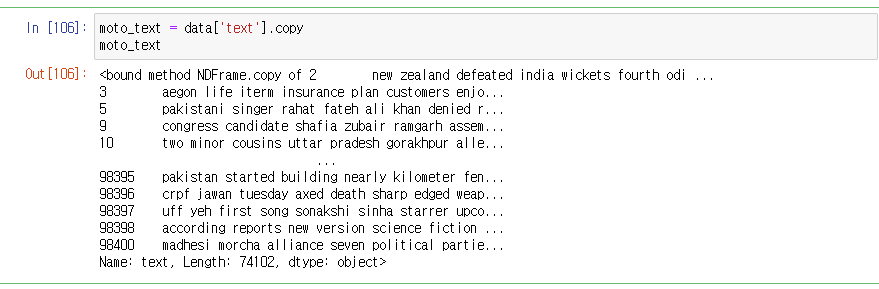  

In [111]:
# 가져오려는 행의 이름과 순서를 알고 있기 때문에 한번 써 봐도 되지않을까? 
# text는 0,1 1번째에 있기 때문에!
# 불러온 moto_text의 type은 dataframe 이다. 
moto_text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1',usecols=[1])
moto_text

,text
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Kunal Shah's credit card bill payment platform...
2,New Zealand defeated India by 8 wickets in the...
3,"With Aegon Life iTerm Insurance plan, customer..."
4,Speaking about the sexual harassment allegatio...
...,...
98396,A CRPF jawan was on Tuesday axed to death with...
98397,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,"According to reports, a new version of the 199..."
98399,A new music video shows rapper Snoop Dogg aimi...



* summrize에서 사용하려면 data가 반드시 ```<str> ```타입 형식의 문자열로 이루어져 있어야 한다.   
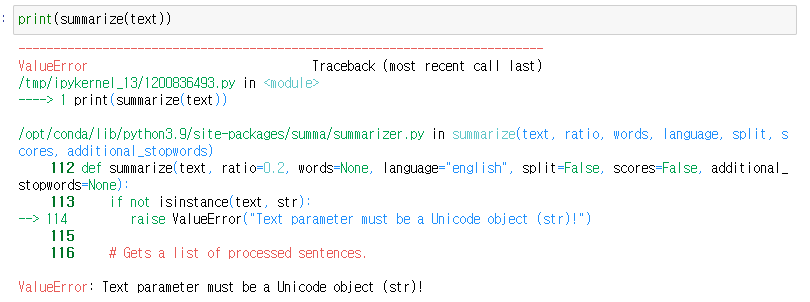  

* 원문과 추상적 요약, 추출적 요약 문장을 비교해 봅시다.  


### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-1 원본 문장


   1. 우선 추상적 요약 문장 하나를 기준으로 잡고, 
   2. 원본 문장에서 검색할 단어들을 선택 해 검색해서 추려보고
   3. 검색 결과가 제일 적게 나왔을 때, 인덱스 번호를 참고해서 하나씩 출력해서 내용을 확인해 본다.
    
    라는 식으로 원본 문장을 찾아보았다. 

In [209]:
moto_text[moto_text['text'].str.contains('sitting alone',case=False)]

,text
17896,Actor Abhishek Bachchan has said that his expe...
33878,After stepping down as Delhi Daredevils' capta...
41943,Australian cricket team members have reportedl...


In [217]:
moto_text['text'][33878]

'After stepping down as Delhi Daredevils\' captain, Gautam Gambhir said he was probably "too desperate to turn things around". "The bell started ringing after the last game...I was sitting alone and thinking, I couldn\'t handle the pressure...I wasn\'t good enough," he added. Delhi Daredevils have lost five of their first six matches in the Indian Premier League 2018.'

### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-2 추상적 요약 문장

In [214]:
exsuma = ExSu(1)

원문 : stepping delhi daredevils captain gautam gambhir said probably desperate turn things around bell started ringing last game sitting alone thinking could handle pressure good enough added delhi daredevils lost five first six matches indian premier league 
실제 요약 : was too desperate to turn things gambhir on stepping down 
예측 요약 :  need to see myself harbhajan on pandya selection row




### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-3 추출적 요약 - ratio 사용

In [239]:
print('Summary:')
print(summarize(moto_text['text'][33878], ratio=0.5))

Summary:
After stepping down as Delhi Daredevils' captain, Gautam Gambhir said he was probably "too desperate to turn things around".


### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-4 추출적 요약 -  출력 할 단어 수를 30개로 설정 


* lms 내 갯수는 50 이였으나, 원문이 짧아 30 로 설정하였다. 

In [240]:
print('Summary:')
print(summarize(moto_text['text'][33878], words= 30))

Summary:
After stepping down as Delhi Daredevils' captain, Gautam Gambhir said he was probably "too desperate to turn things around".
Delhi Daredevils have lost five of their first six matches in the Indian Premier League 2018.


### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-5 추출적 요약 -  출력 결과를 list로 받아볼까요? 

In [224]:
print('Summary:')
print(summarize(moto_text['text'][33878], ratio=0.5, split=True))

Summary:
['After stepping down as Delhi Daredevils\' captain, Gautam Gambhir said he was probably "too desperate to turn things around".']


### &nbsp;&nbsp; &nbsp;&nbsp; 7-2-6 비교 해 봅시다! 


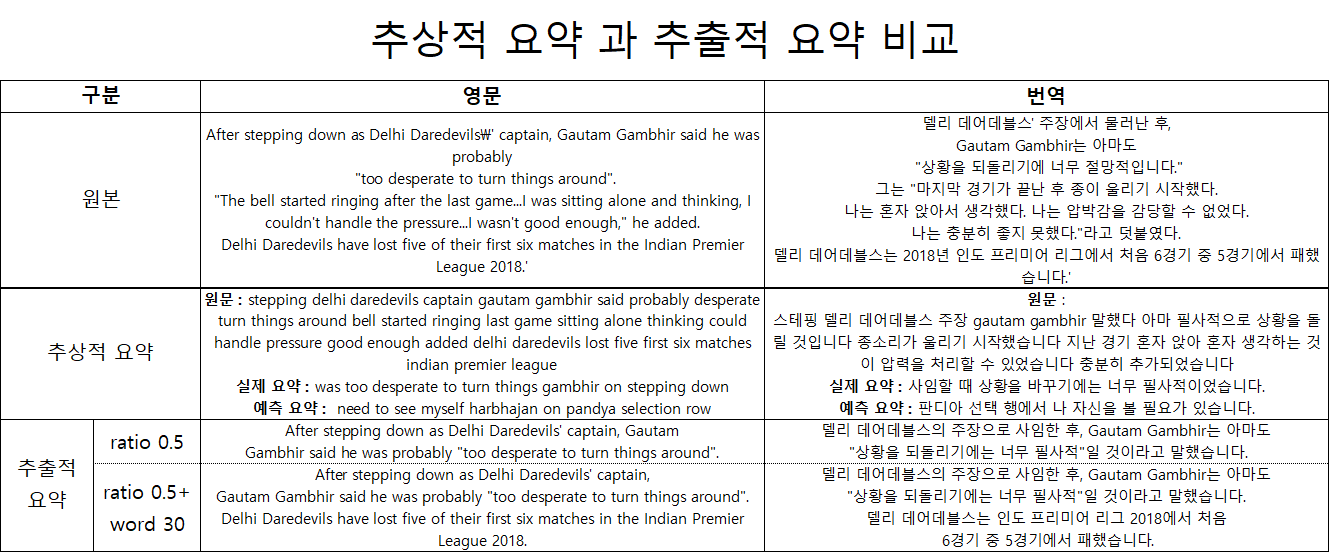  


* 추출적 요약의 결과를 보면, 아무래도 문장에 있는 단어들을 그대로 가져와 조합한 것이기 때문에 추상적 요약보단 훨씬 자연스러워 보인다. word인자를 추가 해 주었더니 기사에서 정말 필요한 부분만을 요약 해 가져온 것 같다. 
* 다만 word를 25로 설정하고 출력했더니, ratio 0.5 로 한 것과 같은 결과가 나왔고, 25 이하로 설정하니 아예 문장자체가 나오지 않았다. 
* list로 만든 부분(7-2-5)은 출력 내용이 같고, list로 출력된것 말곤 다른게 없기 때문에 비교에선 적지 않았습니다. 



* 추상적 요약의 경우, 정제된 원문을 토대로 요약 한 것이기 때문에 요약만 보면 이게 뭘까? 할 수도 있겠다 싶기도 했지만 이 제목을 달고있는 뉴스 기사를 본다면, '뭘 잘못했길래 그랬을까?' 하고 한번쯤은 클릭 해 볼 것 같다. 



----




# 회고! 

* 이번노드.. 내가 글을 읽고 한 문장으로 요약하는건 참 어려운데, 이렇게 모델을 학습시켜 직접 요약해 보니 재밌었다. 재미는 있었지만, 전처리 과정이 너무나도 길었기 때문에 작사가 모델 만들었을 때 보다 복잡하고 길었기 때문에 어렵다고 느꼈던 것 같다. 


* text와 headline의 중복 제외한 샘플의 수를 알아보는 부분이 있었는데,
    > text 열에서 중복을 배제한 유일한 샘플의 수 : 98360  
    headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
    
    로 출력됬던데, 결측치는 없었던걸 보면.. headline은 같은데, text가 다른 부분이 120개나 있었던것 같다. 
    이 부분을 확인 하긴 했지만, 학습 데이터가 줄어들지 않을까 싶어 그대로 진행 했었는데.. 좀 더 공부한 다음에 다시돌아와서 본다면 '아 이부분이 잘못됬는데 이래도 됬네..?' 하면서 신기해 하지않을까? ㅎㅎ.. 

* 추출적 요약 부분을 시도할 때, 어떻게든 str로 된 문장을 가져와야하는데, 어떻게 해 볼까 하면서 고민했던 부분이 제일 재밌었던 부분이였다. 단순히 정제되지 않은 원본 데이터를 가져와서, 붙여넣기만 하면 되는 간단한 작업이였겠지만, 하고있을 당시엔.. 
    1. 원본 문장을 가져와야해!!! 근데 어떻게 가져오지..? -> 정제된걸 가져오면 안되잖아!? 
    2. 가져오긴 가져왔는데 ```<str>``` 로 출력해야 하는데 왜 안되지..?!!?
    ..등등 내적으로 많이 고민해보고, 여러가지 시도를 해 봤던 부분이였다. 
    결국 해 냈지만 하는 과정이 너무 재밌었다 ㅎㅎ 
    
    
    
* 추상적 요약과 추출적 요약을 같은 기사로 비교하고 싶어서 원본 기사를 찾는 과정도 순탄하진 않았다. 인터넷에서 str.contains 에 대한 글을 찾아 '이거라면 해결 해 볼 수 있겠다'라고 생각했지만, 추상적 요약의 원본 문장은 불용어 삭제와 전처리 과정을 거친 문장이라 단어 하나로 찾기엔 중복되는 줄이 100개 이상이였고, 2개 이상으로 찾자니 중간에 생략된 단어가 있어 검색결과가 나오지 않을 때도 있었다. 여러번의 시도를 거쳐 원본 기사를 찾았을때의 그 뿌듯함은 당분간은 잊을 수 없을 것 같다 ㅎㅎ (솔직히 고뇌하는 과정부터 해결 했을때까지가 너무 재밌었어..) 

* 토큰화 과정에서, 처음엔 내가 보기 힘들단 이유로 ```<start>, <end>``` 로 설정해 주고 진행했었는데, 실제 요약과 예측된 요약을 비교하는 과정에서 원인 모를 이유가 계속 발생하였다. 어차피 내가 확인하는게 아니고, 컴퓨터가 확인해서 처리해 주는 부분인데, 구지 바꿔서 시간만 더 지체했던것 같다.. 꺽쇄가 있었기때문에 뭔가 문장으로 처리하지 못해서 오류가 난게 아닐까 라고 생각은 했지만 원인은 역시 모르겠다..

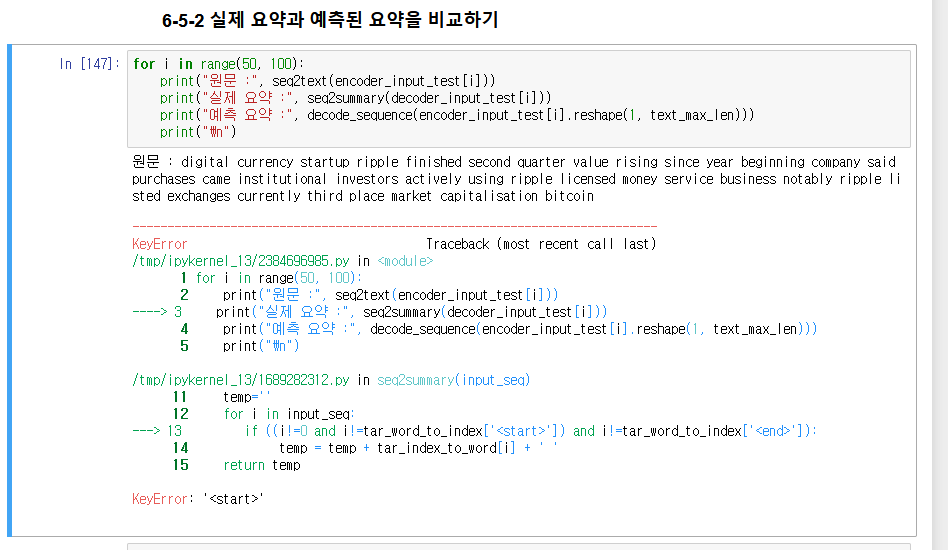

* 별개로 이번 노드.. ```커널 연결중``` 이 역대급으로 떴던 노드라, lms 정리 할 때도 실행이 잘 안되서 로그아웃도 해보고, 클라우드도 꺼보고, 강제 리로드도 해봤었다.. 학습이 힘든거야 당연히 힘든 부분이지만, 기술적으로 안되니깐 어렵기도 해서 더 집중이 안된 부분이 있어 힘들었던 노드였다.... 힘내 서버야..ㅠㅠ 




-----





# 🖇️ 참고 페이지

### pandas 데이터 확인 관련

* [pandas 기초 : csv 파일 불러오기/ 기술통계 / 특정 행과 열 추출하기](https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=bosongmoon&logNo=221572727121)

### summarize 사용하기 

* [파이썬 머신러닝 #7 - 문서 요약하기(TextRank Summariser)](https://steemit.com/dclick/@anpigon/-textrank-summariser-1540351206980)

### DataFrame에서 원하는 문장 찾기

* [pandas 특정 문자로 찾기 str.contains()](https://seong6496.tistory.com/127)